In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Preprocess

In [3]:
train_path = '/content/drive/MyDrive/DM_HW1_DATA/train.csv'

In [4]:
data = pd.read_csv(train_path)
data.drop(columns=['Location', 'Date'], inplace=True)

data['ItemName'] = data['ItemName'].str.replace(' ', '')
replace_values = {'#': None, '*': None, 'x': None, 'A': None}
data.replace(replace_values, inplace=True)
columns_to_convert = data.columns[1:]
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
item_num = len(data['ItemName'].unique())

In [5]:
# fill nan with average by day
new_data = []
new_data_column = data.columns
row, _ = data.shape
for r in range(row):
  row_data = np.array(data.iloc[r, 1:])
  notnan = np.array([tmp for tmp in row_data if not np.isnan(tmp)])
  avg = np.mean(notnan)

  fill_row = []
  for tmp in row_data:
    if not np.isnan(tmp): fill_row.append(tmp)
    else: fill_row.append(avg)
  tmp_row = [data.iloc[r, 0]] + fill_row

  new_data.append(tmp_row)
data = pd.DataFrame(new_data, columns = new_data_column)
print(data)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


        ItemName      0      1      2      3      4      5      6      7  \
0       AMB_TEMP  11.10  11.20  11.40  11.50  11.60  11.70  11.90  12.10   
1            CH4   2.01   1.99   2.00   2.02   2.03   2.02   2.02   2.01   
2             CO   0.31   0.28   0.28   0.33   0.32   0.26   0.25   0.27   
3           NMHC   0.10   0.10   0.08   0.09   0.10   0.07   0.07   0.08   
4             NO   1.50   1.40   1.40   1.50   1.40   1.30   1.40   1.90   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
4315         THC   2.22   2.27   2.20   2.17   2.16   2.20   2.20   2.22   
4316       WD_HR  61.00  57.00  49.00  55.00  62.00  70.00  71.00  62.00   
4317  WIND_DIREC  72.00  34.00  69.00  52.00  60.00  85.00  41.00  66.00   
4318  WIND_SPEED   0.60   0.70   0.60   0.60   0.70   0.30   0.60   0.40   
4319       WS_HR   0.50   0.70   0.50   0.50   0.80   0.30   0.50   0.40   

          8  ...      14      15      16      17      18      19      20  \
0     12.70

In [6]:
row, _ = data.shape
item_names = data.iloc[0:item_num, 0].values.reshape(-1)
item_dic = {name: [] for name in item_names}

# into dictionary
for i in range(0, row, item_num):
    for j, name in enumerate(item_names):
        item_dic[name].append(data.iloc[i + j, 1:].values)

for key, value in item_dic.items():
    item_dic[key] = np.array(value).flatten()

data_filled = pd.DataFrame.from_dict(item_dic)
data_filled = data_filled.apply(pd.to_numeric, errors='coerce')

print(data_filled.head())

   AMB_TEMP   CH4    CO  NMHC   NO   NO2   NOx    O3  PM10  PM2.5  RAINFALL  \
0      11.1  2.01  0.31  0.10  1.5  11.9  13.5  21.6  38.0   25.0       0.0   
1      11.2  1.99  0.28  0.10  1.4  10.4  11.9  25.1  29.0   24.0       0.0   
2      11.4  2.00  0.28  0.08  1.4   9.8  11.2  25.6  27.0   13.0       0.0   
3      11.5  2.02  0.33  0.09  1.5  12.1  13.7  22.4  24.0   14.0       0.0   
4      11.6  2.03  0.32  0.10  1.4  12.4  13.9  21.1  29.0   15.0       0.0   

     RH       SO2   THC  WD_HR  WIND_DIREC  WIND_SPEED  WS_HR  
0  64.0  1.327273  2.11   38.0        53.0         3.0    2.6  
1  65.0  2.100000  2.09   41.0        46.0         3.4    2.4  
2  63.0  2.100000  2.08   49.0        43.0         2.7    2.5  
3  63.0  1.800000  2.11   54.0        54.0         3.0    2.5  
4  63.0  1.100000  2.13   50.0        50.0         2.6    2.1  


Generate model input data

In [7]:
# get the input data form and correlation ###
predict_hours = 9
daily_data = data_filled.to_numpy()
draw_data = []
for i in range(0, row - predict_hours):
    temp = daily_data[i:i+predict_hours, :].transpose().flatten()
    temp = temp.tolist()
    temp.append(daily_data[i + predict_hours, 9]) # column 9 for PM2.5
    draw_data.append(temp)

labels = [[item + str(i) for i in range(predict_hours)] for item in item_names]
labels = np.array(labels).flatten().tolist()

data = pd.DataFrame(draw_data, columns=labels + ['ground_truth'])
print(data.head())

   AMB_TEMP0  AMB_TEMP1  AMB_TEMP2  AMB_TEMP3  AMB_TEMP4  AMB_TEMP5  \
0       11.1       11.2       11.4       11.5       11.6       11.7   
1       11.2       11.4       11.5       11.6       11.7       11.9   
2       11.4       11.5       11.6       11.7       11.9       12.1   
3       11.5       11.6       11.7       11.9       12.1       12.7   
4       11.6       11.7       11.9       12.1       12.7       13.9   

   AMB_TEMP6  AMB_TEMP7  AMB_TEMP8  CH40  ...  WS_HR0  WS_HR1  WS_HR2  WS_HR3  \
0       11.9       12.1       12.7  2.01  ...     2.6     2.4     2.5     2.5   
1       12.1       12.7       13.9  1.99  ...     2.4     2.5     2.5     2.1   
2       12.7       13.9       14.9  2.00  ...     2.5     2.5     2.1     2.1   
3       13.9       14.9       15.7  2.02  ...     2.5     2.1     2.1     2.1   
4       14.9       15.7       16.1  2.03  ...     2.1     2.1     2.1     2.6   

   WS_HR4  WS_HR5  WS_HR6  WS_HR7  WS_HR8  ground_truth  
0     2.1     2.1     2.1   

#### Visualize for anaylsis

Correlation coefficient matrix for hour data

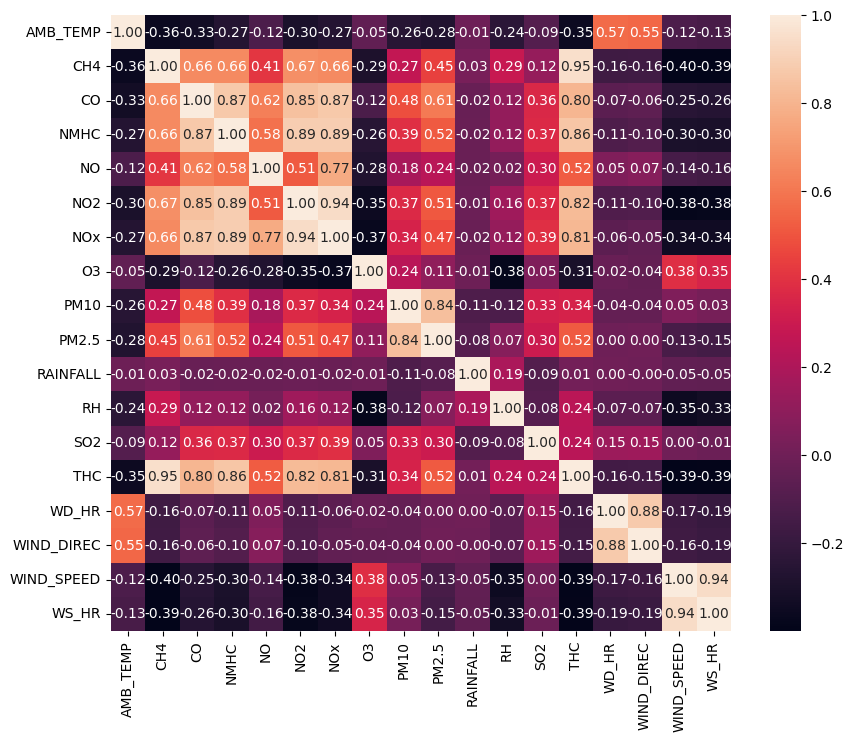

In [8]:
correlation_matrix = data_filled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

## Training

feature selection

In [9]:
correlation = data_filled.corr().loc[:,['PM2.5']]
feature_class = []
for i in correlation.iloc:
  if abs(i['PM2.5']) >= 0.4: feature_class.append(i.name)
print(feature_class)

feature = []
for f in feature_class:
  tmp_feature = [(str(f) + str(i)) for i in range(9)]
  tmp_data = pd.concat([ data.loc[:, tmp_feature], data.loc[:, ['ground_truth']] ], axis = 1)
  tmp_corr = tmp_data.corr().loc[:, ['ground_truth']]

  for i in tmp_corr.iloc:
    if abs(i['ground_truth']) >= 0.4 and i.name != 'ground_truth': feature.append(i.name)

feature.append('ground_truth')
print(feature)

['CH4', 'CO', 'NMHC', 'NO2', 'NOx', 'PM10', 'PM2.5', 'THC']
['CH46', 'CH47', 'CH48', 'CO0', 'CO1', 'CO2', 'CO3', 'CO4', 'CO5', 'CO6', 'CO7', 'CO8', 'NMHC5', 'NMHC6', 'NMHC7', 'NMHC8', 'NO24', 'NO25', 'NO26', 'NO27', 'NO28', 'NOx5', 'NOx6', 'NOx7', 'NOx8', 'PM100', 'PM101', 'PM102', 'PM103', 'PM104', 'PM105', 'PM106', 'PM107', 'PM108', 'PM2.50', 'PM2.51', 'PM2.52', 'PM2.53', 'PM2.54', 'PM2.55', 'PM2.56', 'PM2.57', 'PM2.58', 'THC4', 'THC5', 'THC6', 'THC7', 'THC8', 'ground_truth']


In [10]:
training_data = data[feature].dropna()
print(training_data.head())

training_dataset = training_data.to_numpy().astype(np.float64)

   CH46  CH47  CH48   CO0   CO1   CO2   CO3   CO4   CO5   CO6  ...  PM2.55  \
0  2.02  2.01  2.03  0.31  0.28  0.28  0.33  0.32  0.26  0.25  ...    12.0   
1  2.01  2.03  2.03  0.28  0.28  0.33  0.32  0.26  0.25  0.27  ...    10.0   
2  2.03  2.03  2.01  0.28  0.33  0.32  0.26  0.25  0.27  0.32  ...    10.0   
3  2.03  2.01  2.01  0.33  0.32  0.26  0.25  0.27  0.32  0.34  ...    11.0   
4  2.01  2.01  1.99  0.32  0.26  0.25  0.27  0.32  0.34  0.33  ...    11.0   

   PM2.56  PM2.57  PM2.58  THC4  THC5  THC6  THC7  THC8  ground_truth  
0    10.0    10.0    11.0  2.13  2.09  2.09  2.09  2.13          11.0  
1    10.0    11.0    11.0  2.09  2.09  2.09  2.13  2.12          10.0  
2    11.0    11.0    10.0  2.09  2.09  2.13  2.12  2.09          16.0  
3    11.0    10.0    16.0  2.09  2.13  2.12  2.09  2.10          13.0  
4    10.0    16.0    13.0  2.13  2.12  2.09  2.10  2.07          15.0  

[5 rows x 49 columns]


training

In [48]:
def split_data(training_dataset, ratio):
  np.random.seed(0)
  np.random.shuffle(training_dataset)
  training_x = training_dataset[:int(ratio * training_dataset.shape[0]), :-1]
  training_y = training_dataset[:int(ratio * training_dataset.shape[0]), -1].reshape(-1, 1)
  testing_x = training_dataset[int(ratio * training_dataset.shape[0]):, :-1]
  testing_y = training_dataset[int(ratio * training_dataset.shape[0]):, -1].reshape(-1, 1)

  return training_x, training_y, testing_x, testing_y

In [49]:
class CustomStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        return self

    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise ValueError("Scaler has not been fitted.")
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [50]:
class LR():
    def __init__(self, input_size, output_size):
        self.weight = np.ones((input_size, output_size))
        self.intercept = np.ones(output_size)
        self.input = None

    def forward(self, x):
        self.m, _ = x.shape
        self.input = x
        predict = np.dot(x, self.weight) + self.intercept
        return predict

    def backward(self, gradient, lamb, lr):
        update = np.dot(gradient, self.weight.T)

        # regularize
        self.weight *= (1 - lr*lamb/self.m)

        self.weight -= (lr/self.m) * np.dot(self.input.T, gradient)
        self.intercept -= lr * np.sum(gradient, axis=0)
        return update

In [51]:
def train(lr, lamb, model, train_x, train_y, epochs):
    for i in range(epochs):
      predict = model.forward(train_x)
      loss = np.mean((predict - train_y) ** 2)
      gradient = 2 * (predict - train_y)
      update = model.backward(gradient, lamb, lr)
      if i % 10000 == 0:
        print('Epoch:', i, 'Loss:', loss)
    return loss

ratio:  0.5
Epoch: 0 Loss: 1032.8092511617285
Epoch: 10000 Loss: 15.161004129030617
Epoch: 20000 Loss: 15.05777254958921
Epoch: 30000 Loss: 15.023939930014327
Epoch: 40000 Loss: 15.008293083962581
Epoch: 50000 Loss: 14.999669875044892
Epoch: 60000 Loss: 14.994333101398468
Epoch: 70000 Loss: 14.9907830853753
Epoch: 80000 Loss: 14.988316957327703
Epoch: 90000 Loss: 14.986556829476509
ratio:  0.6
Epoch: 0 Loss: 1035.6089169779673
Epoch: 10000 Loss: 15.284837316730714
Epoch: 20000 Loss: 15.18332058016399
Epoch: 30000 Loss: 15.147069622052461
Epoch: 40000 Loss: 15.127793942784304
Epoch: 50000 Loss: 15.116520691298915
Epoch: 60000 Loss: 15.109616327108885
Epoch: 70000 Loss: 15.105242082605514
Epoch: 80000 Loss: 15.102387638633353
Epoch: 90000 Loss: 15.100474030903989
ratio:  0.7
Epoch: 0 Loss: 1025.0805098621595
Epoch: 10000 Loss: 15.559765260324887
Epoch: 20000 Loss: 15.507963138077885
Epoch: 30000 Loss: 15.491579308362953
Epoch: 40000 Loss: 15.483314320133468
Epoch: 50000 Loss: 15.47856046

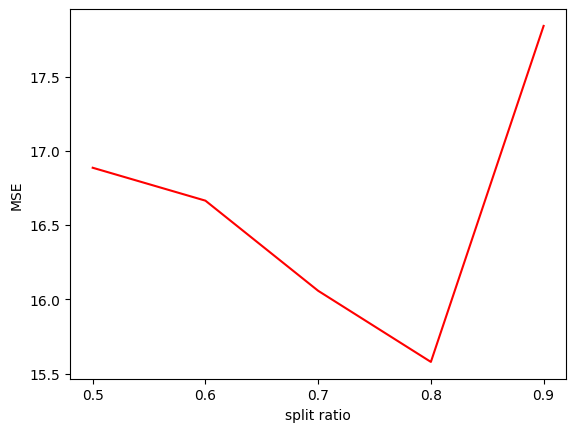

In [45]:
ratio = [0.5, 0.6, 0.7, 0.8, 0.9]
total_loss = []
for i in ratio:
  print("ratio: ", i)
  training_x, training_y, testing_x, testing_y = split_data(training_dataset = training_dataset, ratio = i)

  scaler = CustomStandardScaler()
  scaler.fit(training_x)
  std_train_x = scaler.transform(training_x)
  std_test_x = scaler.transform(testing_x)

  model = LR(std_train_x.shape[1], 1)
  train_loss = train(lr = 1e-4, lamb = 10, model = model, train_x = std_train_x, train_y = training_y, epochs = 100000)

  predict = model.forward(std_test_x)
  loss = np.mean((predict - testing_y) ** 2)

  total_loss.append(loss)

print(total_loss)

plt.plot(ratio, total_loss, 'r')
ax = plt.gca()
x_space = plt.MultipleLocator(0.1)
ax.xaxis.set_major_locator(x_space)
plt.ylabel("MSE")
plt.xlabel("split ratio")
plt.show()

lambda:  0
Epoch: 0 Loss: 1016.8603355562814
Epoch: 10000 Loss: 18.693586366734216
Epoch: 20000 Loss: 17.103066911892018
Epoch: 30000 Loss: 16.506169346684572
Epoch: 40000 Loss: 16.194999989110595
Epoch: 50000 Loss: 16.010856048900482
Epoch: 60000 Loss: 15.89360685370629
Epoch: 70000 Loss: 15.814797180001811
Epoch: 80000 Loss: 15.759327353479005
Epoch: 90000 Loss: 15.718638099250732
lambda:  10
Epoch: 0 Loss: 1030.6622846824848
Epoch: 10000 Loss: 18.183244552703677
Epoch: 20000 Loss: 16.738315267661587
Epoch: 30000 Loss: 16.210055354559522
Epoch: 40000 Loss: 15.938302652500196
Epoch: 50000 Loss: 15.780434782651572
Epoch: 60000 Loss: 15.682202985519337
Epoch: 70000 Loss: 15.617954840618326
Epoch: 80000 Loss: 15.57414201209443
Epoch: 90000 Loss: 15.543121534743095
lambda:  100
Epoch: 0 Loss: 1004.1164037154293
Epoch: 10000 Loss: 18.129176732286318
Epoch: 20000 Loss: 16.57124667661064
Epoch: 30000 Loss: 16.010413593978527
Epoch: 40000 Loss: 15.720893013106393
Epoch: 50000 Loss: 15.5483826

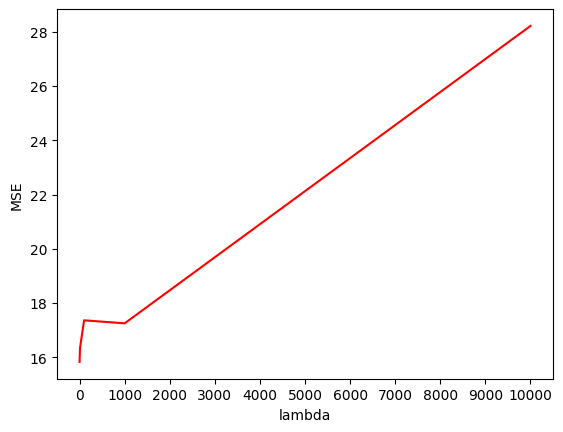

In [63]:
lamb = [0, 10, 100, 1000, 10000]
total_loss = []
for i in lamb:
  print("lambda: ", i)
  training_x, training_y, testing_x, testing_y = split_data(training_dataset = training_dataset, ratio = 0.7)

  scaler = CustomStandardScaler()
  scaler.fit(training_x)
  std_train_x = scaler.transform(training_x)
  std_test_x = scaler.transform(testing_x)

  model = LR(std_train_x.shape[1], 1)
  train_loss = train(lr = 1e-4, lamb = i, model = model, train_x = std_train_x, train_y = training_y, epochs = 100000)

  predict = model.forward(std_test_x)
  loss = np.mean((predict - testing_y) ** 2)

  total_loss.append(loss)

print(total_loss)

plt.plot(lamb, total_loss, 'r')
ax = plt.gca()
x_space = plt.MultipleLocator(1000)
ax.xaxis.set_major_locator(x_space)
plt.ylabel("MSE")
plt.xlabel("lambda")
plt.show()

In [52]:
training_x, training_y, testing_x, testing_y = split_data(training_dataset = training_dataset, ratio = 0.7)

In [53]:
scaler = CustomStandardScaler()
scaler.fit(training_x)
std_train_x = scaler.transform(training_x)
std_test_x = scaler.transform(testing_x)

In [ ]:
model = LR(std_train_x.shape[1], 1)
training_loss = train(lr = 1e-4, lamb = 10, model = model, train_x = std_train_x, train_y = training_y, epochs = 1000000)

predict = model.forward(std_test_x)
loss = np.mean((predict - testing_y) ** 2)
print("test loss: ", loss)

## inference

In [ ]:
test_path = '/content/drive/MyDrive/DM_HW1_DATA/test.csv'

In [ ]:
header = ['index', 'ItemName', '0', '1', '2', '3', '4', '5', '6', '7', '8']
data = pd.read_csv(test_path, names = header, index_col='index')
data['ItemName'] = data['ItemName'].str.replace(' ', '')
replace_values = {'#': None, '*': None, 'x': None, 'A': None}
data.replace(replace_values, inplace=True)
columns_to_convert = data.columns[1:]
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')
item_num = len(data['ItemName'].unique())

In [ ]:
# fill nan with average by day
new_data = []
new_data_column = data.columns
row, _ = data.shape
for r in range(row):
  row_data = np.array(data.iloc[r, 1:])
  notnan = np.array([tmp for tmp in row_data if not np.isnan(tmp)])
  avg = np.mean(notnan)

  fill_row = []
  for tmp in row_data:
    if not np.isnan(tmp): fill_row.append(tmp)
    else: fill_row.append(avg)
  tmp_row = [data.iloc[r, 0]] + fill_row

  new_data.append(tmp_row)
data = pd.DataFrame(new_data, columns = new_data_column)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
row, _ = data.shape
item_names = data.iloc[0:item_num, 0].values.reshape(-1)
item_dic = {name: [] for name in item_names}

# into dictionary
for i in range(0, row, item_num):
    for j, name in enumerate(item_names):
        item_dic[name].append(data.iloc[i + j, 1:].values)

for key, value in item_dic.items():
    item_dic[key] = np.array(value).flatten()

data_filled = pd.DataFrame.from_dict(item_dic)
data_filled = data_filled.apply(pd.to_numeric, errors='coerce')

In [ ]:
# get the input data form ###
predict_hours = 9
daily_data = data_filled.to_numpy()
data = []
for i in range(0, daily_data.shape[0], predict_hours):
    temp = daily_data[i: i + predict_hours, :].transpose().flatten()
    temp = temp.tolist()
    data.append(temp)
labels = [[item + str(i) for i in range(predict_hours)] for item in item_names]
labels = np.array(labels).flatten().tolist()
data = pd.DataFrame(data, columns=labels)

In [ ]:
# feature = ['CH46', 'CH47', 'CH48', 'CO0', 'CO1', 'CO2', 'CO3', 'CO4', 'CO5', 'CO6', 'CO7', 'CO8', 'NMHC5', 'NMHC6', 'NMHC7', 'NMHC8', 'NO24', 'NO25', 'NO26', 'NO27', 'NO28', 'NOx5', 'NOx6', 'NOx7', 'NOx8', 'PM100', 'PM101', 'PM102', 'PM103', 'PM104', 'PM105', 'PM106', 'PM107', 'PM108', 'PM2.50', 'PM2.51', 'PM2.52', 'PM2.53', 'PM2.54', 'PM2.55', 'PM2.56', 'PM2.57', 'PM2.58', 'THC4', 'THC5', 'THC6', 'THC7', 'THC8']
test_feature = feature[0:-1]
test_data = data[test_feature].dropna()
test_dataset = test_data.to_numpy().astype(np.float64)

std_inference_x = scaler.transform(test_dataset)

In [ ]:
# inference
predict = model.forward(std_inference_x)
predict = predict.flatten().tolist()
print(predict.shape)

ans = [['index_'+str(i), predict[i]] for i in range(len(predict))]
df = pd.DataFrame(ans, columns=['index', 'answer'])
df.to_csv('predict.csv', index=False)

(244,)
